In [88]:
%matplotlib inline

import numpy as np
import subprocess
import sys

import matplotlib.pyplot as plt

In [8]:
print(sys.executable)
print(sys.path)

/home/junxianh/anaconda3/bin/python3.7
['/projects/junxianh/sparse-prototype/noedit_analysis', '/home/junxianh/anaconda3/lib/python37.zip', '/home/junxianh/anaconda3/lib/python3.7', '/home/junxianh/anaconda3/lib/python3.7/lib-dynload', '', '/home/junxianh/.local/lib/python3.7/site-packages', '/home/junxianh/anaconda3/lib/python3.7/site-packages', '/projects/junxianh/support-prototype/support_prototype/sentence-transformers', '/home/junxianh/anaconda3/lib/python3.7/site-packages/files2rouge-2.1.0-py3.7.egg', '/home/junxianh/anaconda3/lib/python3.7/site-packages/compare_mt-0.2.8-py3.7.egg', '/home/junxianh/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/junxianh/.ipython']


In [12]:
import faiss

In [9]:
!conda install faiss-cpu -c pytorch

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.9.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [13]:
def get_file_len(file):
    proc = subprocess.run(['wc', '-l', file], capture_output=True)
    return int(proc.stdout.decode('utf-8').split()[0])

In [14]:
import os
print(os.getcwd())

/projects/junxianh/sparse-prototype/noedit_analysis


In [15]:
template_size = get_file_len('../datasets/yelp_large/template.txt')
valid_size = get_file_len('../datasets/yelp_large/valid.txt')
emb_size = 768

In [60]:
template_emb = np.memmap('../precompute_embedding_datasets/yelp_large/yelp_large.sentbert.template.npy', 
                    dtype='float16', mode='r', shape=(template_size, emb_size))
valid_emb = np.memmap('../precompute_embedding_datasets/yelp_large/yelp_large.sentbert.valid.npy', 
                    dtype='float16', mode='r', shape=(valid_size, emb_size))

In [61]:
print(template_emb)

[[-0.2113  -0.01338  0.531   ... -0.5327  -0.03918 -0.2961 ]
 [-0.2573   0.02672  1.175   ...  0.1211  -0.308    0.787  ]
 [-0.0904   0.3406   1.476   ...  0.7197  -0.2773   0.2842 ]
 ...
 [ 0.1992   0.299    0.2054  ...  0.642    0.424    0.2109 ]
 [-0.804    0.9385   0.2654  ...  0.132    0.122   -0.0909 ]
 [ 0.8193   0.65     0.4514  ... -0.257   -0.3196   0.1863 ]]


In [62]:
print(valid_emb)

[[ 0.00828  0.4495   1.583   ... -0.0928  -0.1848   0.03275]
 [-0.711    0.878   -0.94    ...  0.368    0.61     0.0641 ]
 [-0.8345   0.4722  -0.0204  ...  0.414    0.5605   0.4238 ]
 ...
 [ 0.03552 -0.05728  1.345   ...  0.6504  -0.409    0.0566 ]
 [ 0.01875  0.8726   2.422   ...  0.2097  -0.06726  0.04877]
 [-0.4746  -0.12305  1.401   ...  1.112   -0.03296 -0.489  ]]


In [63]:
template_data = open('../datasets/yelp_large/template.txt').readlines()
valid_data = open('../datasets/yelp_large/valid.txt').readlines()

In [64]:
template_emb = np.array(template_emb).astype('float32')
print(template_emb)

[[-0.21130371 -0.01338196  0.5307617  ... -0.53271484 -0.03918457
  -0.29614258]
 [-0.25732422  0.02671814  1.1748047  ...  0.12109375 -0.30810547
   0.7871094 ]
 [-0.09039307  0.34057617  1.4755859  ...  0.71972656 -0.27734375
   0.2841797 ]
 ...
 [ 0.19921875  0.29907227  0.20544434 ...  0.64208984  0.42407227
   0.2109375 ]
 [-0.8041992   0.93847656  0.26538086 ...  0.13195801  0.12200928
  -0.09088135]
 [ 0.81933594  0.64990234  0.45141602 ... -0.25708008 -0.31958008
   0.1862793 ]]


In [65]:
valid_emb = np.array(valid_emb).astype('float32')

In [66]:
from sklearn.preprocessing import normalize
template_emb = normalize(template_emb, axis=1)

In [67]:
valid_emb = normalize(valid_emb, axis=1)

In [68]:
(template_emb * template_emb).sum(axis=1)

array([0.9999999 , 0.99999994, 1.0000002 , ..., 1.        , 1.        ,
       0.9999999 ], dtype=float32)

In [69]:
template_emb.shape

(100000, 768)

In [97]:
import faiss
index = faiss.IndexFlatIP(emb_size)
print(index.is_trained)
index.add(template_emb)                  # add vectors to the index
print(index.ntotal)

True
100000


In [98]:
D, I = index.search(valid_emb, 5) # sanity check

In [99]:
print(D)

[[0.7925476  0.79238915 0.79052603 0.78799057 0.78507817]
 [0.9085925  0.9029808  0.8988961  0.89215755 0.89167154]
 [0.92036927 0.9027685  0.89818484 0.89783216 0.89503366]
 ...
 [0.75926757 0.75683093 0.75237393 0.75205714 0.7511725 ]
 [0.9256618  0.92386377 0.91661    0.910743   0.90552545]
 [0.974928   0.94852996 0.9451724  0.93355584 0.9201683 ]]


In [100]:
print(I)

[[95238 87880 57042 42061 49706]
 [ 1688 44397 66679 28129 41701]
 [12665 13476 85531 12083 77450]
 ...
 [37789 89939 91219 26259 49408]
 [39362 19719 62399 74750 98084]
 [87730 65118 19099 80549 37688]]


In [101]:
print(I[1000])
print(D[1000])

[14972 55648 17331 19528 16967]
[0.8682054  0.8550117  0.83839893 0.83595216 0.83267117]


In [104]:
print(I[997])
print(D[997])
D[997].mean()

[98673 70975 27912  5900  9372]
[0.942031   0.92259324 0.91906476 0.90577376 0.8967124 ]


0.917235

In [159]:
from typing import List, Tuple
def _sim_to_id(sim: float, bin_bound: List[Tuple[int, int]]) -> str:
    """convert the length into the id of bucket, return the string of the id
    Args:
        length: the length to be converted
        bin_bound: the bucket denoted by a list of tuples
    """
    flag = False
    for i, bucket in enumerate(bin_bound):
        if sim >= bucket[0] and sim < bucket[1]:
            id_ = i
            flag = True
            break

    if not flag:
        raise ValueError("didn't find a bucket for sim {}".format(sim))

    return id_

In [172]:
def plot_ll_difference(scale='large'):
    def read_file(fname):
        res = {}
        with open(fname) as fin:
            for i, line in enumerate(fin):
                id_, tokens, ll = line.rstrip().split()
                id_ = int(id_)
                tokens = int(tokens)
                ll = float(ll)
                assert id_ not in res
                
                res[id_] = (tokens, ll)

        return res, len(res)
    
    data_prototype, _ = read_file(f'prototype/loss_yelp_{scale}.txt')
    data_lm, _ = read_file(f'lm/loss_yelp_{scale}.txt')
    
#     print(data_prototype)
    res = []
    for i in range(len(data_lm)):
        assert data_prototype[i][0] == data_lm[i][0]
        diff = (data_prototype[i][1] / data_prototype[i][0]) - (data_lm[i][1] / data_lm[i][0])
        res.append((D[i][0], data_prototype[i], data_lm[i]))
#         res.append((D[i][0], diff))

    all_sim = [x[0] for x in res]
    all_sim = sorted(all_sim)

    bucket_num = 10
    avg_bin_len = len(all_sim) // bucket_num
    bin_bound = []

    for i in range(bucket_num):
        if i == (bucket_num - 1):
            bin_bound.append((all_sim[i * avg_bin_len], 1.))
        else:
            bin_bound.append((all_sim[i * avg_bin_len], all_sim[(i+1) * avg_bin_len]))
            
    res_dict = {i: {'ntok': 0, 'll_prot': 0, 'll_lm':0} for i in range(len(bin_bound))}
    for x in res:
        id_ = _sim_to_id(x[0], bin_bound)
        res_dict[id_]['ntok'] += x[1][0]
        res_dict[id_]['ll_prot'] += x[1][1]
        res_dict[id_]['ll_lm'] += x[2][1]
        
    labels = [f'bucket {i}' for i in range(len(bin_bound))]
    prototype_ppl = [np.exp(-res_dict[i]['ll_prot'] / res_dict[i]['ntok']) for i in range(len(bin_bound))]
    lm_ppl = [np.exp(-res_dict[i]['ll_lm'] / res_dict[i]['ntok']) for i in range(len(bin_bound))]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 7))
    rects1 = ax.bar(x - width/2, prototype_ppl, width, label='protype')
    rects2 = ax.bar(x + width/2, lm_ppl, width, label='LM')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('ppl')
    ax.set_title('ppl by different cos sim buckets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()
    
    return res

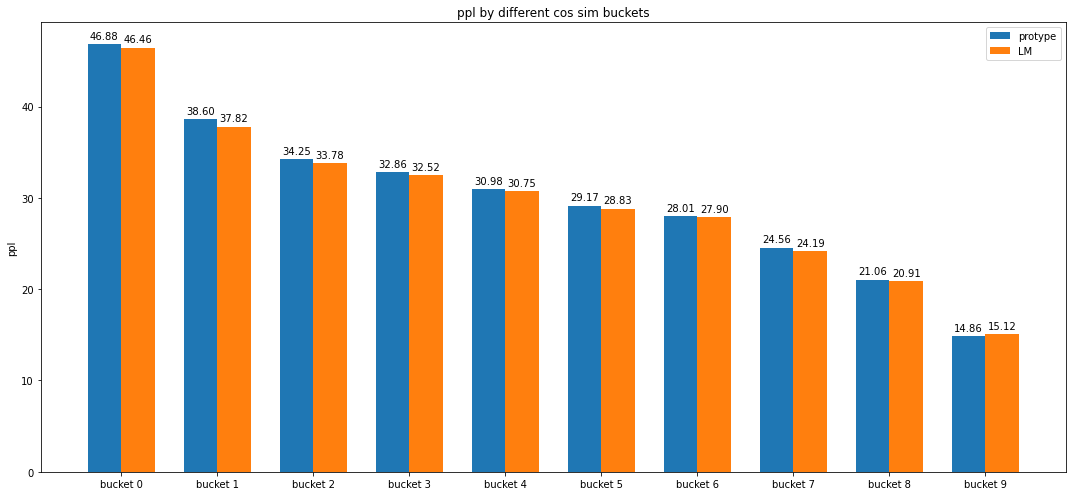

In [174]:
res = plot_ll_difference('large')

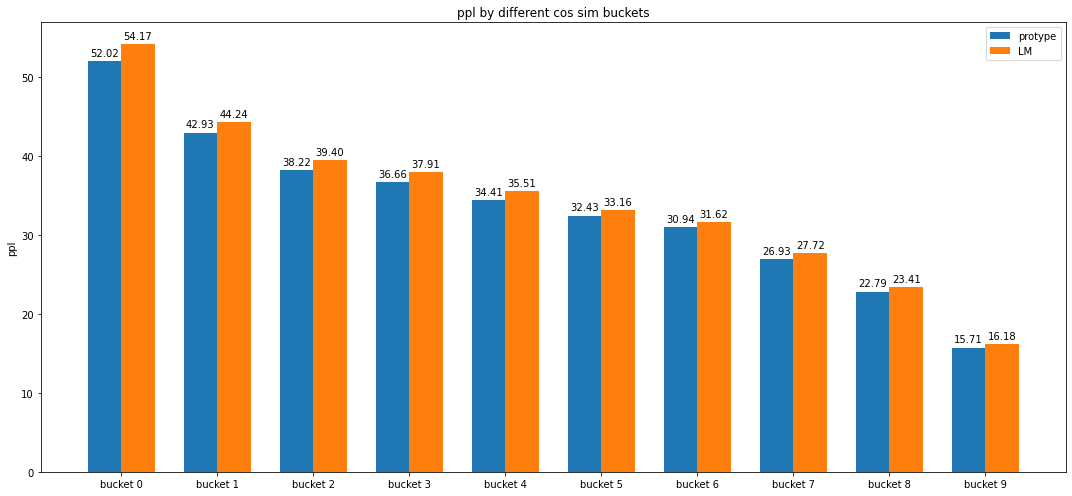

In [175]:
res = plot_ll_difference('medium')

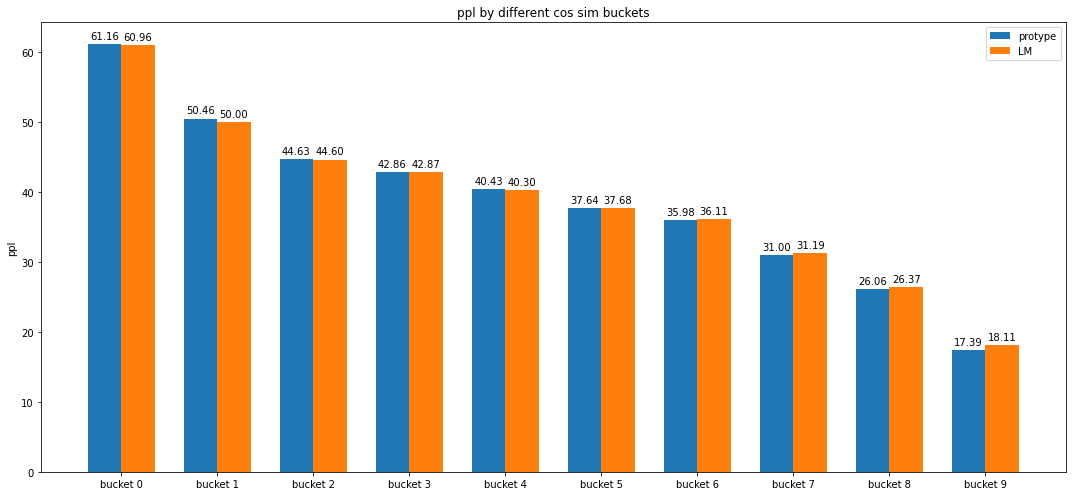

In [199]:
res = plot_ll_difference('xs')

In [206]:
def plot_ll_frequency(scale='large'):
    def read_file(fname):
        res = {}
        with open(fname) as fin:
            for i, line in enumerate(fin):
                id_, tokens, ll = line.rstrip().split()
                id_ = int(id_)
                tokens = int(tokens)
                ll = float(ll)
                assert id_ not in res
                
                res[id_] = (tokens, ll)

        return res, len(res)
    
    data_prototype, _ = read_file(f'prototype/loss_yelp_{scale}.txt')
    data_lm, _ = read_file(f'lm/loss_yelp_{scale}.txt')
    
    dict_ = {}
    with open(f'../data-bin/yelp_large/dict.txt') as fin:
        for line in fin:
            word, count = line.split()
            count = int(count)
            dict_[word] = count
            
#     template_data = open('../datasets/yelp_large/template.txt').readlines()
    valid_data = open('../datasets/yelp_large/valid.txt').readlines()
    
    oov = set()
    def get_minimum_freq(sentence):
        toks = sentence.strip().split()
        freqs = [dict_.get(tok, 0) for tok in toks]
        for freq, tok in zip(freqs, toks):
            if freq == 0:
                oov.update([tok])
        return min(freqs)
    
#     print(data_prototype)
    res = []
    for i in range(len(data_lm)):
        assert data_prototype[i][0] == data_lm[i][0]
        diff = (data_prototype[i][1] / data_prototype[i][0]) - (data_lm[i][1] / data_lm[i][0])
        res.append((get_minimum_freq(valid_data[i]), data_prototype[i], data_lm[i]))
#         res.append((D[i][0], diff))

#     print(oov)

    all_sim = [x[0] for x in res]
    all_sim = sorted(all_sim)

    bucket_num = 10
    avg_bin_len = len(all_sim) // bucket_num
    bin_bound = []

    for i in range(bucket_num):
        if i == (bucket_num - 1):
            bin_bound.append((all_sim[i * avg_bin_len], 1e8))
        else:
            bin_bound.append((all_sim[i * avg_bin_len], all_sim[(i+1) * avg_bin_len]))
            
    bin_bound = [(0, 1035), (1035, 2131), (2131, 3944), (3944, 6655), (6655, 11184), (11184, 19791), (19791, 38580), (38580, 100000000.0)]
    print(bin_bound)
    res_dict = {i: {'ntok': 0, 'll_prot': 0, 'll_lm':0} for i in range(len(bin_bound))}
    for x in res:
        id_ = _sim_to_id(x[0], bin_bound)
        res_dict[id_]['ntok'] += x[1][0]
        res_dict[id_]['ll_prot'] += x[1][1]
        res_dict[id_]['ll_lm'] += x[2][1]
    
#     print(res_dict)
        
    labels = [f'bucket {i}' for i in range(len(bin_bound))]
    prototype_ppl = [np.exp(-res_dict[i]['ll_prot'] / res_dict[i]['ntok']) for i in range(len(bin_bound))]
    lm_ppl = [np.exp(-res_dict[i]['ll_lm'] / res_dict[i]['ntok']) for i in range(len(bin_bound))]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 7))
    rects1 = ax.bar(x - width/2, prototype_ppl, width, label='protype')
    rects2 = ax.bar(x + width/2, lm_ppl, width, label='LM')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('ppl')
    ax.set_title('ppl by different cos sim buckets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()
    
#     return res

[(0, 1035), (1035, 2131), (2131, 3944), (3944, 6655), (6655, 11184), (11184, 19791), (19791, 38580), (38580, 100000000.0)]


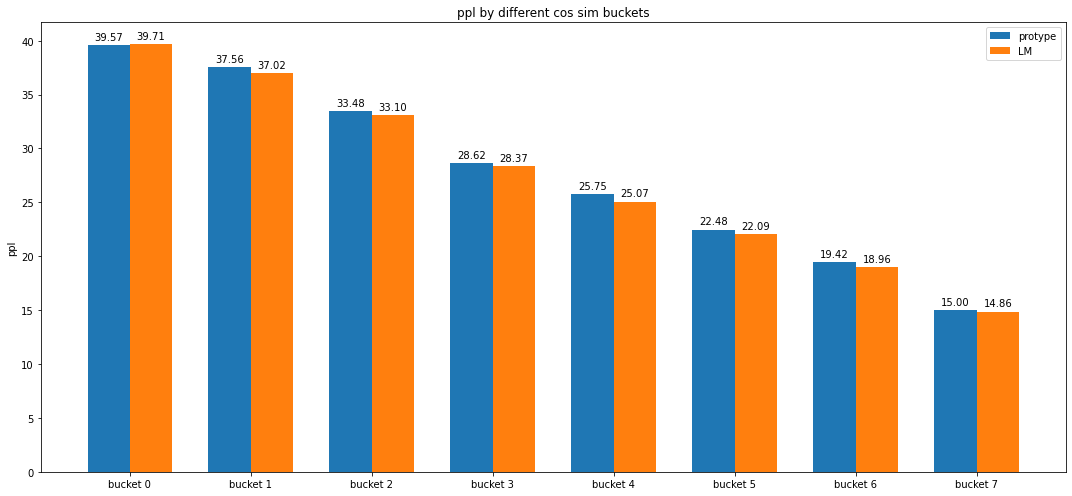

In [207]:
plot_ll_frequency('large')

[(0, 1035), (1035, 2131), (2131, 3944), (3944, 6655), (6655, 11184), (11184, 19791), (19791, 38580), (38580, 100000000.0)]


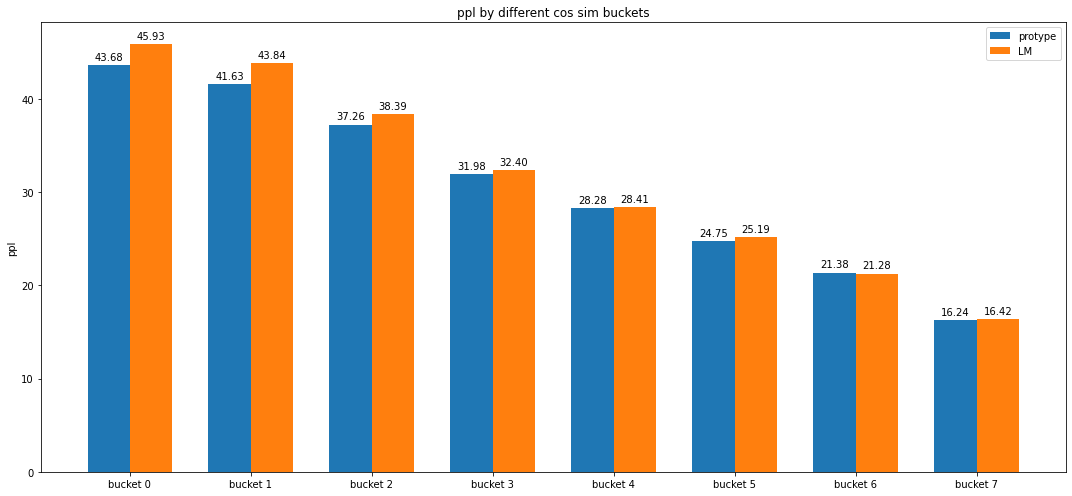

In [208]:
plot_ll_frequency('medium')

[(0, 1035), (1035, 2131), (2131, 3944), (3944, 6655), (6655, 11184), (11184, 19791), (19791, 38580), (38580, 100000000.0)]


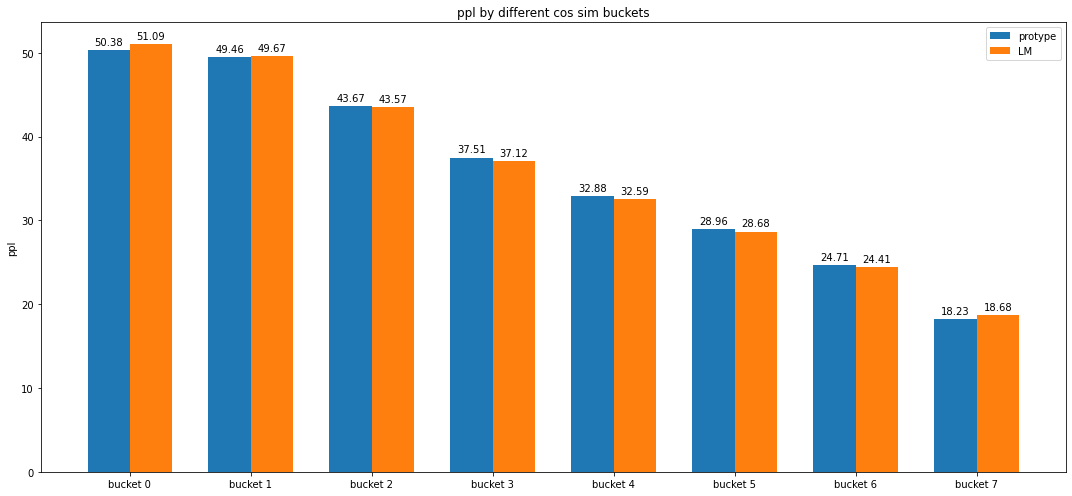

In [209]:
plot_ll_frequency('xs')

In [150]:
res_dict = {i: {'ntok': 0, 'll_prot': 0, 'll_lm':0} for i in range(len(bin_bound))}
for x in res:
    id_ = _sim_to_id(x[0], bin_bound)
    res_dict[id_]['ntok'] += x[1][0]
    res_dict[id_]['ll_prot'] += x[1][1]
    res_dict[id_]['ll_lm'] += x[2][1]

In [151]:
res_dict

{0: {'ntok': 18181,
  'll_prot': -70270.54110527039,
  'll_lm': -70117.30881690979},
 1: {'ntok': 19680,
  'll_prot': -71868.66791057587,
  'll_lm': -71460.53864479065},
 2: {'ntok': 19724,
  'll_prot': -69540.54462814331,
  'll_lm': -69233.75874137878},
 3: {'ntok': 19581, 'll_prot': -68123.3238620758, 'll_lm': -68157.44058036804},
 4: {'ntok': 19138,
  'll_prot': -65444.09323787689,
  'll_lm': -65173.15997695923},
 5: {'ntok': 18488,
  'll_prot': -62281.59392642975,
  'll_lm': -62201.330163002014},
 6: {'ntok': 17755, 'll_prot': -58571.8714799881, 'll_lm': -58435.81583213806},
 7: {'ntok': 16777,
  'll_prot': -54251.398158073425,
  'll_lm': -54039.92406463623},
 8: {'ntok': 15208,
  'll_prot': -46955.22489070892,
  'll_lm': -46804.46427345276},
 9: {'ntok': 12077,
  'll_prot': -33192.08258724213,
  'll_lm': -33240.12480926514}}

In [153]:
for i in range(len(bin_bound)):
    print(f"cos sim {bin_bound[i]}: prototype ppl {np.exp(-res_dict[i]['ll_prot'] / res_dict[i]['ntok'])}, \
          lm ppl {np.exp(-res_dict[i]['ll_lm'] / res_dict[i]['ntok'])}")

cos sim (0.5737529, 0.75071955): prototype ppl 47.70583360455008,           lm ppl 47.305451051664875
cos sim (0.75071955, 0.7794898): prototype ppl 38.54641913457433,           lm ppl 37.75526481005669
cos sim (0.7794898, 0.79998666): prototype ppl 33.97692568875588,           lm ppl 33.45253937771503
cos sim (0.79998666, 0.8170158): prototype ppl 32.428975854057015,           lm ppl 32.48552733912567
cos sim (0.8170158, 0.8327921): prototype ppl 30.55685190592278,           lm ppl 30.127311626755702
cos sim (0.8327921, 0.84764785): prototype ppl 29.042427697367742,           lm ppl 28.9166162605953
cos sim (0.84764785, 0.864958): prototype ppl 27.082681899229517,           lm ppl 26.875941837681797
cos sim (0.864958, 0.8843573): prototype ppl 25.3727800567871,           lm ppl 25.054963399018074
cos sim (0.8843573, 0.9089452): prototype ppl 21.922960540589465,           lm ppl 21.706706540272318
cos sim (0.9089452, 1.0): prototype ppl 15.617178565525597,           lm ppl 15.679427323

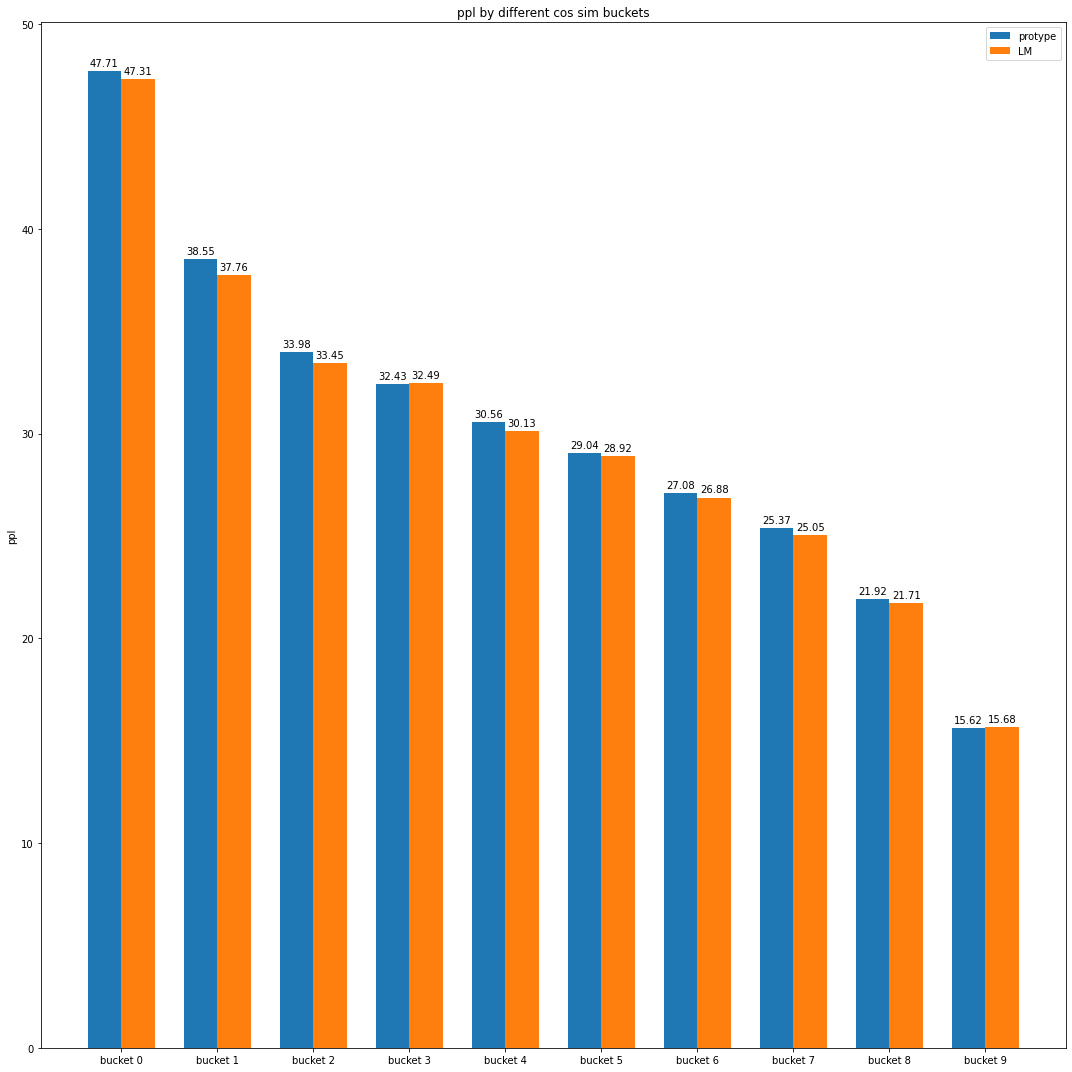

In [158]:
labels = [f'bucket {i}' for i in range(len(bin_bound))]
prototype_ppl = [np.exp(-res_dict[i]['ll_prot'] / res_dict[i]['ntok']) for i in range(len(bin_bound))]
lm_ppl = [np.exp(-res_dict[i]['ll_lm'] / res_dict[i]['ntok']) for i in range(len(bin_bound))]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 15))
rects1 = ax.bar(x - width/2, prototype_ppl, width, label='protype')
rects2 = ax.bar(x + width/2, lm_ppl, width, label='LM')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ppl')
ax.set_title('ppl by different cos sim buckets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [126]:
from collections import Counter
total = Counter()
win = Counter()
for x in res:
    id_ = int(x[0] / 0.1)
    assert id_ < 10
    total[id_] += 1
    if x[1][1] > x[2][1]:
        win[id_] +=1
    
print(win)
print(total)
    
for i in range(n_bucket):
    print(f'bucket sim {buckets[i]} - {buckets[i]}+0.1: {win[i] / total[i]} win')

Counter({8: 2696, 7: 1224, 9: 618, 6: 122, 5: 2})
Counter({8: 5684, 7: 2757, 9: 1314, 6: 240, 5: 5})


ZeroDivisionError: division by zero

In [ ]:
for i in range()